# World Data League 2022

## 🎯 Challenge
*Predicting the flow of people for public transportation improvements*

## 👥 Authors
* Antonio Oliveira
* Any Pereira
* Hayanne Oliveira
* Israel Souza
* Martim Chaves

## 💻 Development

# 1. Imports

In [1]:
# If needed
#!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import seaborn as sns
import json
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import os
# DL
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# 2. Reading the dataset and preliminary data cleaning

In [3]:
os.listdir("./data_stage2")

['202001_Validações Ferrov.xlsx',
 '202008_Validações Ferrov.xlsx',
 '202002_Validações Ferrov.xlsx',
 '202009_Validações Ferrov.xlsx',
 '202005_Validações Ferrov.xlsx',
 '202010_Validações Ferrov.xlsx',
 '202006_Validações Ferrov.xlsx',
 '202004_Validações Ferrov.xlsx',
 '202003_Validações Ferrov.xlsx',
 '202007_Validações Ferrov.xlsx',
 '202011_Validações Ferrov.xlsx',
 '202012_Validações Ferrov.xlsx']

In [4]:
months = []

In [5]:
for month_file in os.listdir("./data_stage2"):
    month_vals = pd.read_excel(os.path.join("./data_stage2",month_file))
    months.append(month_vals)
rail_2020 = pd.concat(months)

## 2.1. What does the dataset look like? (EDA)

In [6]:
rail_2020.head()

,Ano,Mês,Dia,Hora,Operador,Est/Op,Zona,Validações
0,2020,1,1,0,CP-Porto,CP-Porto / Aguda,VNG8,1
1,2020,1,1,0,CP-Porto,CP-Porto / Cête,PRD2,2
2,2020,1,1,0,CP-Porto,CP-Porto / Ermesinde,MAI4,3
3,2020,1,1,0,CP-Porto,CP-Porto / Espinho,VNG8,1
4,2020,1,1,0,CP-Porto,CP-Porto / Famalicão,,1


### How many stations are there? (Est/Op)

In [7]:
rail_2020["Est/Op"].unique()

array(['CP-Porto / Aguda', 'CP-Porto / Cête', 'CP-Porto / Ermesinde',
       'CP-Porto / Espinho', 'CP-Porto / Famalicão', 'CP-Porto / Miramar',
       'CP-Porto / Rio Tinto', 'CP-Porto / Trofa', 'CP-Porto / Valongo',
       'Alto da Pêga', 'Araújo', 'Bolhão', 'Câmara de Gaia',
       'Câmara de Matosinhos', 'Carolina de Michaelis', 'Casa da Música',
       'Castêlo da Maia', 'Custoias', 'D. João II', 'Esposade',
       'Estádio do Dragão', 'Fânzeres', 'Fonte do Cuco - Linha P',
       'Fórum', 'General Torres', 'H. Pedro Hispano', 'Heroísmo', 'IPO',
       'ISMAI', 'Jardim do Morro', 'Lidador', 'Marquês', 'Mercado',
       'Mindelo', 'Modivas Centro', 'Modivas Norte', 'Nasoni',
       'Nau Vitória', 'Parque da Maia', 'Parque de Real', 'Pedras Rubras',
       'Portas Fronhas', 'Póvoa de Varzim', 'Ramalde', 'São Bento',
       'São Brás', 'Vasco da Gama', 'Verdes', 'Vila do Conde',
       'CP-Porto / Campanhã', 'CP-Porto / Coimbrões',
       'CP-Porto / Cortegaça', 'CP-Porto / Couto Cam

It's quite a long a list! The stations that have "CP-Porto" at the beggining are related to train railways, whereas the ones that don't are related to the subway.

### When were the measures being done?

First, let's rename some columns!

In [8]:
rail_2020.rename({'Ano': 'year', 'Mês': 'month', 'Dia': 'day', 'Hora': 'hour',
                 'Operador': 'operator', 'Est/Op': 'station', 'Zona': 'zone', 'Validações': 'validations'}, axis=1, inplace=True)

In [9]:
rail_2020["hour"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

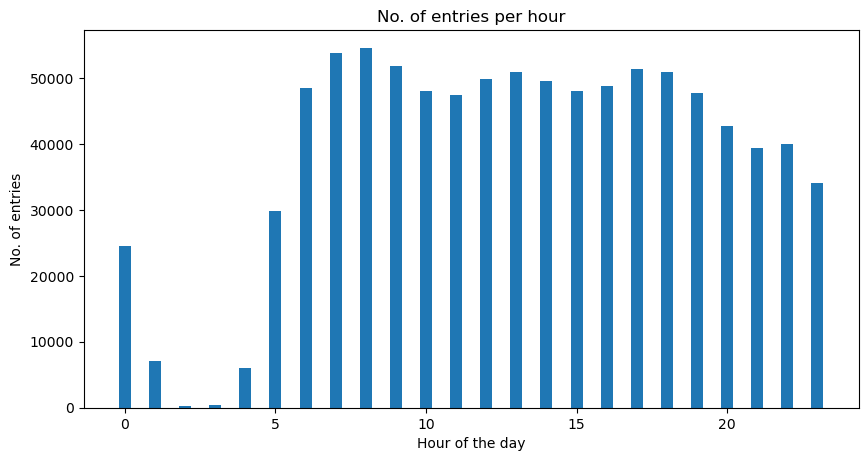

In [10]:
uniq_hours = np.unique(rail_2020["hour"].values, return_counts=True)
hours, h_count = uniq_hours[0], uniq_hours[1]

# Plot bar chart
fig = plt.figure(figsize = (10, 5), dpi=100)
 
# creating the bar plot
plt.bar(hours, h_count, width = 0.4)
 
plt.xlabel("Hour of the day")
plt.ylabel("No. of entries")
plt.title("No. of entries per hour")
plt.show()

There are very few measurements done for the hours of 2 am to 4 am (understandable, as there are fewer trains/subways operating in that area.

In [11]:
def check_dist_data(df, time_measure = "hour", xlabel = "Hour of the day"):
    uniq_time = np.unique(df[time_measure].values, return_counts=True)
    time, t_count = uniq_time[0], uniq_time[1]

    # Plot bar chart
    fig = plt.figure(figsize = (10, 5), dpi=100)

    # creating the bar plot
    plt.bar(time, t_count, width = 0.4)

    plt.xlabel(xlabel)
    plt.ylabel("No. of entries")
    plt.title(f"No. of entries per {time_measure}")
    plt.show()

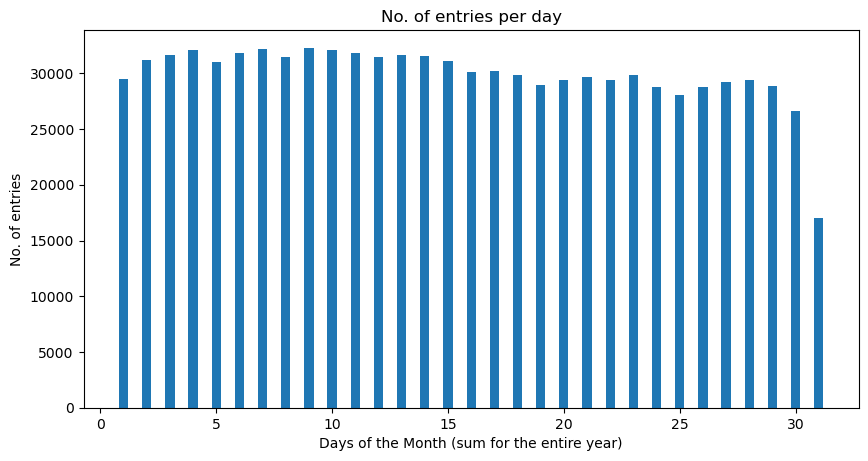

In [12]:
check_dist_data(rail_2020, time_measure = "day", xlabel = "Days of the Month (sum for the entire year)")

We assume that rhe dips for the 30th and the 31st of May are related to not all months having those days.

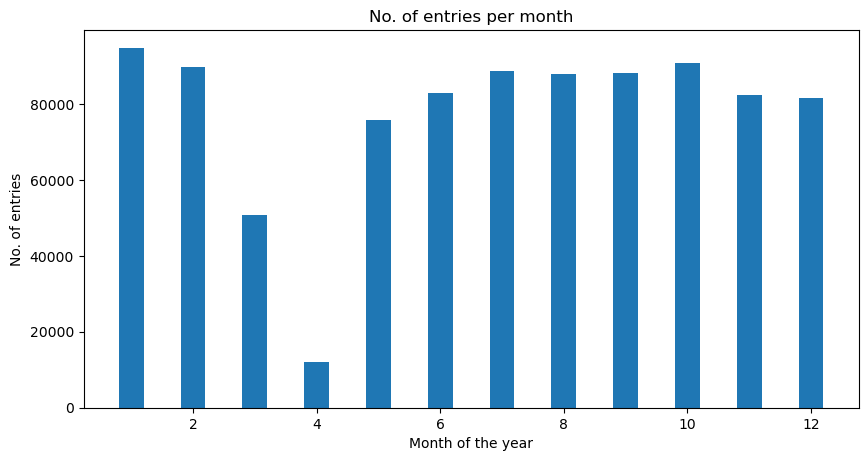

In [13]:
check_dist_data(rail_2020, time_measure = "month", xlabel = "Month of the year")

Only a few measurements were done in the month of April. Considering that this is the first pandemic year, it may be possible that in April a lot of services were not being run (confusing times). Thus, we may have to be careful with conclusions made regarding the month of April. The same may be true for the month of March and May. However, for the remaining months, it seems like regular-ish activities were carried out. Let's add the day of the week each entry is.

In [14]:
rail_2020['date'] = pd.to_datetime(rail_2020[['year', 'month', 'day', 'hour']])
day_week_dict = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thurs',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}
rail_2020['day_week'] = [day_week_dict[d.dayofweek] for d in rail_2020.date]

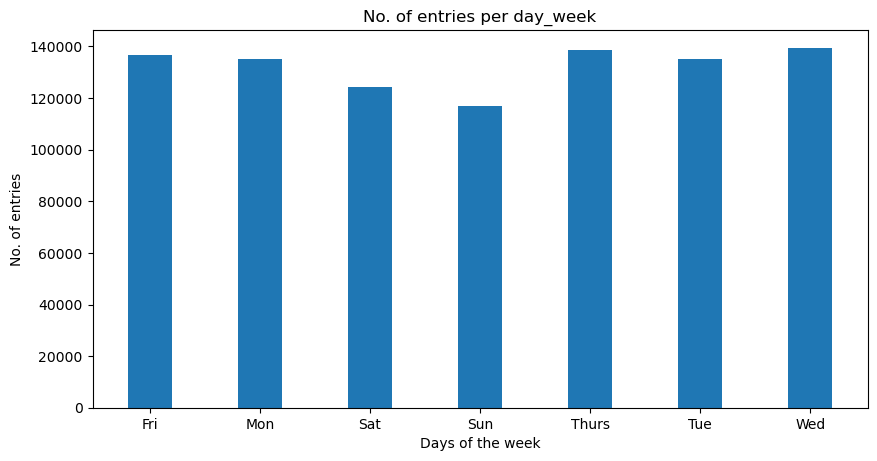

In [15]:
check_dist_data(rail_2020, time_measure = "day_week", xlabel = "Days of the week")

### How many values are missing?

In [16]:
rail_2020.isnull().sum()

year           0
month          0
day            0
hour           0
operator       0
station        0
zone           0
validations    0
date           0
day_week       0
dtype: int64

Apparently, there aren't any missing values. But that does not seem to be the case! The 4th index has a missing zone

In [17]:
rail_2020.iloc[4]['zone']

'          '

In [18]:
type(rail_2020.iloc[4]['zone'])

str

It's not "missing", it's instead a string of blanks

In [19]:
rail_2020[rail_2020['zone']=='          ']

,year,month,day,hour,operator,station,zone,validations,date,day_week
4,2020,1,1,0,CP-Porto,CP-Porto / Famalicão,,1,2020-01-01 00:00:00,Wed
53,2020,1,1,1,CP-Porto,CP-Porto / Cortegaça,,1,2020-01-01 01:00:00,Wed
54,2020,1,1,1,CP-Porto,CP-Porto / Couto Cambeses,,2,2020-01-01 01:00:00,Wed
56,2020,1,1,1,CP-Porto,CP-Porto / Famalicão,,50,2020-01-01 01:00:00,Wed
136,2020,1,1,1,CP-Porto,CP-Porto / Nine,,7,2020-01-01 01:00:00,Wed
...,...,...,...,...,...,...,...,...,...,...
81611,2020,12,31,22,CP-Porto,CP-Porto / Braga,,1,2020-12-31 22:00:00,Thurs
81618,2020,12,31,22,CP-Porto,CP-Porto / Estarreja,,6,2020-12-31 22:00:00,Thurs
81620,2020,12,31,22,CP-Porto,CP-Porto / Louro,,1,2020-12-31 22:00:00,Thurs
81622,2020,12,31,22,CP-Porto,CP-Porto / Meinedo,,2,2020-12-31 22:00:00,Thurs


Quite a few entries have a missing zone! Let's leave those in for now.

In [20]:
rail_2020['validations'].describe()

count    926852.000000
mean         54.590226
std         166.490216
min           1.000000
25%           3.000000
50%          11.000000
75%          42.000000
max        6624.000000
Name: validations, dtype: float64

The median is around 11 validations. The mean is quite skewed due to the very high max value. Let's look at an histogram of the values.

<AxesSubplot:>

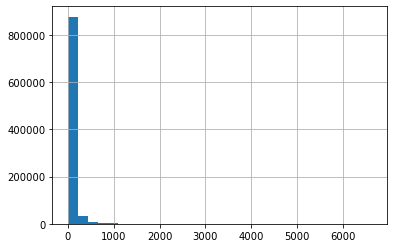

In [21]:
rail_2020['validations'].hist(bins=30)

That's not very helpful. It seems that this distribution has quite a long tail (some entries have a very high number of validations, whereas most entries have fewer that 1000 validations); let's look at the log

<AxesSubplot:>

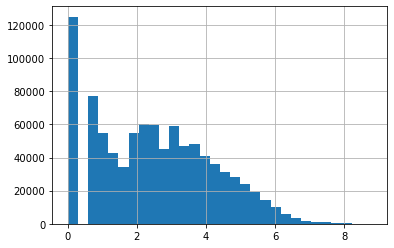

In [22]:
np.log(rail_2020['validations']).hist(bins=30) # natural log (of e)

Let's look at some of the outliers :)

In [23]:
sorted_indx = rail_2020['validations'].argsort()
# top 10 peaks
top_10 = rail_2020.iloc[sorted_indx[:-10:-1]]
top_10 = top_10.sort_values(by='validations')
print(f"Top 10 days:\n{top_10[['date','station','validations']]}")

Top 10 days:
                     date   station  validations
33814 2020-02-11 18:00:00  Trindade         6117
17663 2020-01-06 18:00:00  Trindade         6150
30576 2020-02-10 18:00:00  Trindade         6155
37267 2020-02-12 18:00:00  Trindade         6196
86348 2020-02-27 17:00:00  Trindade         6257
64160 2020-02-20 18:00:00  Trindade         6391
60409 2020-02-19 18:00:00  Trindade         6391
53405 2020-02-18 18:00:00  Trindade         6508
50174 2020-02-17 18:00:00  Trindade         6624


Unsurprisingly, the highest entries were obtained during peak hours. Note that all of them are for the first 2 months. This means that after the first few cases of covid, rail public transports did not have the same amount of influx of people as it was probably expected. Note that for all of these entries the station is Trindade. This makes sense, as Trindade is one of the largest traportations hub in Porto. Since a validation is essentially a person saying "I am here", our conclusion from this is that a lot of people are in Trindade during peak hours... We don't really need amazing data science for that haha! People that are in downtown are going home after work. Perhaps then, it may be interesting to explore where people came from in the morning, to have an idea of where people are going at around 6pm (18h). 

In [24]:
rail_morning_6_jan = rail_2020[(rail_2020['day']==6)&(rail_2020['month']==1)&(rail_2020['hour']<=10)]

In [25]:
sorted_indx_m_6_jan = rail_morning_6_jan['validations'].argsort() #m for morning
# top 10 peaks
top_30_m_6_jan = rail_morning_6_jan.iloc[sorted_indx_m_6_jan[:-30:-1]]
top_30_m_6_jan = top_30_m_6_jan.sort_values(by='validations')
print(f"Top 10 days:\n{top_30_m_6_jan[['date','station','validations']]}")

Top 10 days:
                     date               station  validations
15068 2020-01-06 07:00:00      CP-Porto / Braga          632
15643 2020-01-06 10:00:00        Casa da Música          632
15312 2020-01-06 08:00:00     Estádio do Dragão          644
15211 2020-01-06 07:00:00          João de Deus          648
15316 2020-01-06 08:00:00           H. São João          651
15483 2020-01-06 09:00:00        Casa da Música          671
15591 2020-01-06 09:00:00             São Bento          692
15706 2020-01-06 10:00:00              Campanhã          701
15375 2020-01-06 08:00:00        Casa da Música          735
15224 2020-01-06 07:00:00           Srª da Hora          750
15298 2020-01-06 08:00:00          24 de Agosto          764
15384 2020-01-06 08:00:00        General Torres          772
15564 2020-01-06 09:00:00           Srª da Hora          822
15083 2020-01-06 07:00:00  CP-Porto / Ermesinde          823
15378 2020-01-06 08:00:00            D. João II          838
15330 2020-

Looking at the top 30 stations in the morning, the story seems to be a little bit more interesting. We can start to tell from which stations people depart. Perhaps a connection may be established between which stations people are commuting, in order to better determine how many train/subway wagons are needed... Future work! For now, we'll focus on the busiest subway stations, *preferably* (but not necessarily) the ones at the beggining/end of a subway line, with a high influx of people, such as Santo Ovídio, Campanhã, Trindade, Srª da Hora, Estádio do Dragão, and H. São João. The reason why begginings/ends of lines are preferred is because those allow us to directly determine how many wagons should be there at a given time, whereas validation number of stations in the 'middle' of the network don't tell us where people are going. 

Let's look at some more yearly trends!

In [26]:
def plt_time_graph(df,stations_lst, ymax = 700, freq_time = '3D'):
    
    validations_stations = pd.DataFrame()
    
    for station_name in stations_lst:
        df_station = df[df['station']==station_name]
        
        df_station_ts = df_station.groupby(pd.Grouper(key='date', axis=0,freq=freq_time)).mean()
        
        df_station_ts.index.name = 'date'
        df_station_ts.reset_index(inplace=True)
        df_station_rolled_df = df_station_ts
        
        validations_stations[station_name] = df_station_rolled_df['validations'] 
    
    dates = df_station_rolled_df['date']
    
    plt.plot(dates, validations_stations, label=stations_lst)
    plt.title(f"Validations throughout the year ({freq_time} frequency)")
    plt.xlabel("Date")
    plt.ylabel("Validations")
    plt.legend()
    plt.xticks(rotation=45)

    fig = plt.gcf() #get current figure
    #fig.set_size_inches(18.5, 10.5, forward=True)
    fig.set_dpi(100)
    
    ax = plt.gca()
    ax.set_ylim([0, ymax])
    
    plt.show()

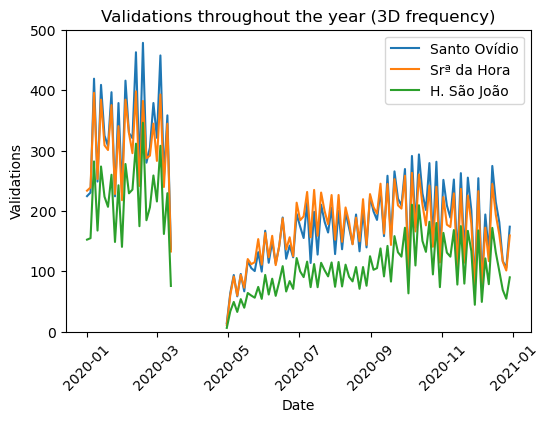

In [27]:
stations_list = ['Santo Ovídio','Srª da Hora','H. São João']
plt_time_graph(rail_2020,stations_list, ymax=500)

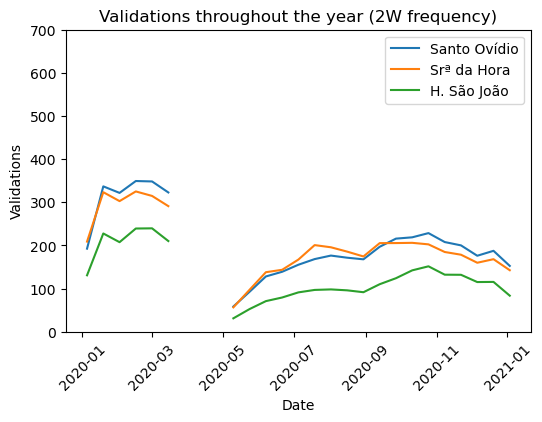

In [28]:
stations_list = ['Santo Ovídio','Srª da Hora','H. São João']
plt_time_graph(rail_2020,stations_list, freq_time="2W")

It's interesting how these 'main' subway stations tend to 'behave' similarly!

In [29]:
def draw_boxplot_pol(df,station_name="H. São João",offliers=True):
    
    working_df = df[df['station']==station_name]
    
    # Draw Plot
    fig, axes = plt.subplots(1, 3, figsize=(20,7), dpi= 80)
    fig.suptitle(f"Number of validations at the {station_name} station", fontsize=30, y=1.05)
    sns.boxplot(x='month', y='validations', data=working_df, ax=axes[0], showfliers = offliers)
    
    sns.boxplot(x='day_week', y='validations', data=working_df, ax=axes[1], order=[
                 'Mon','Tue','Wed','Thurs','Fri','Sat','Sun'], showfliers = offliers)
    
    sns.boxplot(x='hour', y='validations', data=working_df, ax=axes[2], showfliers = offliers)

    # Set Title
    axes[0].set_title('Month-wise Box Plot\n(Yearly Seasonality)', fontsize=18)
    axes[1].set_title('Day-wise Box Plot\n(Weekly Seasonality)', fontsize=18)
    axes[2].set_title('Hour-wise Box Plot\n(Hourly Seasonality)', fontsize=18)
    plt.show()

<a id='important_graph_1'><b>Important graph 1!</b> Shows the seasonality associated with validations at subway stations, and how that is related to peak hours.</a>

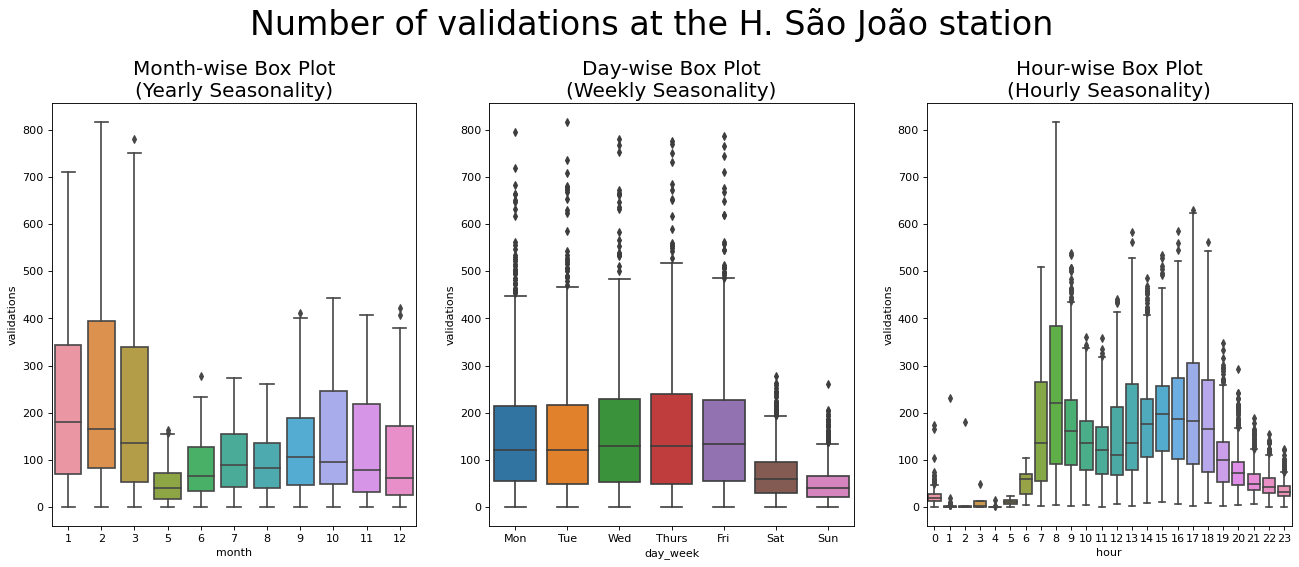

In [30]:
draw_boxplot_pol(rail_2020)

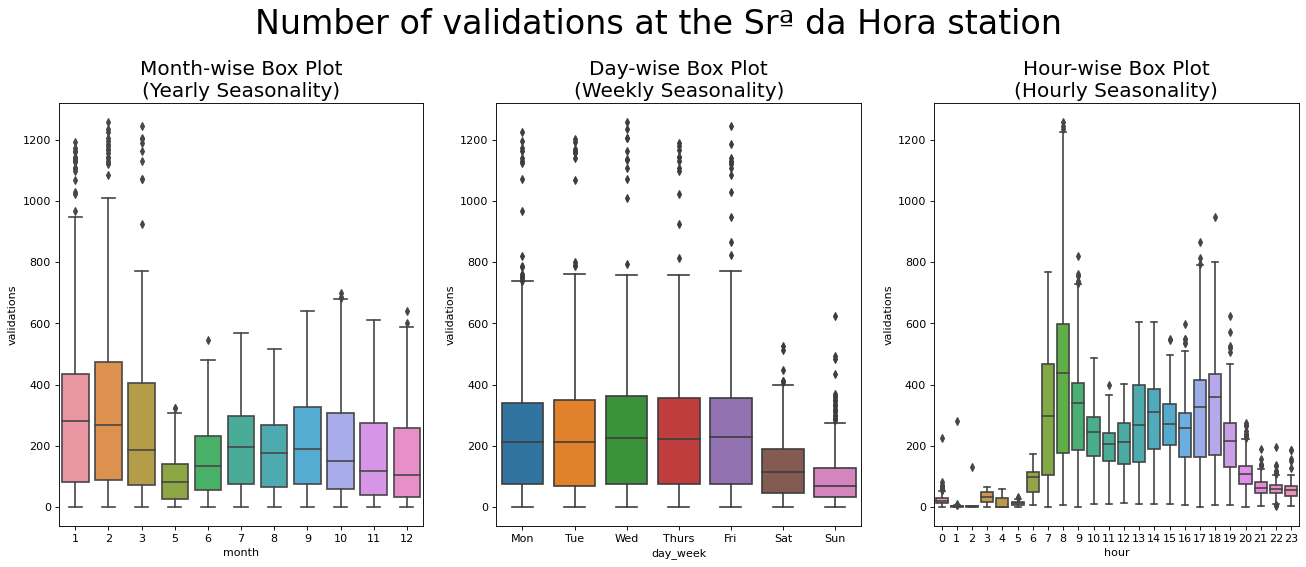

In [31]:
draw_boxplot_pol(rail_2020, station_name = 'Srª da Hora')

# 3. Feature Engineering

Considering the effect of the covid pandemic, it was thought that adding a column explicitly saying whether or not the pandemic had started would be beneficial to a model. Furthermore, we wanted to focus on those specific subway stations (Santo Ovídio, Campanhã, Trindade, Srª da Hora, Estádio do Dragão, and H. São João), so a new dataframe is required.

In [32]:
subset_rail_2020 = rail_2020[(rail_2020['station']=='Santo Ovídio') | 
                             (rail_2020['station']=='Campanhã') | 
                             (rail_2020['station']=='Trindade') | 
                             (rail_2020['station']=='Srª da Hora') | 
                             (rail_2020['station']=='Estádio do Dragão') | 
                             (rail_2020['station']=='H. São João')].copy()

In [33]:
subset_rail_2020.head()

,year,month,day,hour,operator,station,zone,validations,date,day_week
20,2020,1,1,0,Metro do Porto,Estádio do Dragão,PRT1,129,2020-01-01 00:00:00,Wed
64,2020,1,1,1,Metro do Porto,Campanhã,PRT1,112,2020-01-01 01:00:00,Wed
72,2020,1,1,1,Metro do Porto,Estádio do Dragão,PRT1,138,2020-01-01 01:00:00,Wed
75,2020,1,1,1,Metro do Porto,H. São João,PRT3,231,2020-01-01 01:00:00,Wed
100,2020,1,1,0,Metro do Porto,Campanhã,PRT1,76,2020-01-01 00:00:00,Wed


In [34]:
# drop some cols
subset_rail_2020.drop(['operator', 'zone'], axis=1, inplace=True)

In [35]:
subset_rail_2020

,year,month,day,hour,station,validations,date,day_week
20,2020,1,1,0,Estádio do Dragão,129,2020-01-01 00:00:00,Wed
64,2020,1,1,1,Campanhã,112,2020-01-01 01:00:00,Wed
72,2020,1,1,1,Estádio do Dragão,138,2020-01-01 01:00:00,Wed
75,2020,1,1,1,H. São João,231,2020-01-01 01:00:00,Wed
100,2020,1,1,0,Campanhã,76,2020-01-01 00:00:00,Wed
...,...,...,...,...,...,...,...,...
81705,2020,12,31,23,Campanhã,5,2020-12-31 23:00:00,Thurs
81716,2020,12,31,23,H. São João,1,2020-12-31 23:00:00,Thurs
81730,2020,12,31,23,Santo Ovídio,1,2020-12-31 23:00:00,Thurs
81733,2020,12,31,23,Srª da Hora,3,2020-12-31 23:00:00,Thurs


In [36]:
subset_rail_2020_expanded = subset_rail_2020.pivot_table(values='validations',\
                                      index=subset_rail_2020.date,\
                                      columns='station', aggfunc='first')
subset_rail_2020_expanded.index.name = 'date'
subset_rail_2020_expanded.reset_index(inplace=True)
subset_rail_2020_expanded.head()

station,date,Campanhã,Estádio do Dragão,H. São João,Santo Ovídio,Srª da Hora,Trindade
0,2020-01-01 00:00:00,76.0,129.0,174.0,203.0,226.0,4562.0
1,2020-01-01 01:00:00,112.0,138.0,231.0,284.0,282.0,4250.0
2,2020-01-01 02:00:00,45.0,53.0,180.0,91.0,132.0,2988.0
3,2020-01-01 03:00:00,29.0,21.0,48.0,31.0,66.0,2004.0
4,2020-01-01 04:00:00,29.0,6.0,16.0,12.0,58.0,2287.0


In [37]:
subset_rail_2020_expanded

station,date,Campanhã,Estádio do Dragão,H. São João,Santo Ovídio,Srª da Hora,Trindade
0,2020-01-01 00:00:00,76.0,129.0,174.0,203.0,226.0,4562.0
1,2020-01-01 01:00:00,112.0,138.0,231.0,284.0,282.0,4250.0
2,2020-01-01 02:00:00,45.0,53.0,180.0,91.0,132.0,2988.0
3,2020-01-01 03:00:00,29.0,21.0,48.0,31.0,66.0,2004.0
4,2020-01-01 04:00:00,29.0,6.0,16.0,12.0,58.0,2287.0
...,...,...,...,...,...,...,...
6908,2020-12-31 19:00:00,78.0,39.0,40.0,41.0,59.0,503.0
6909,2020-12-31 20:00:00,29.0,13.0,38.0,19.0,30.0,219.0
6910,2020-12-31 21:00:00,10.0,8.0,19.0,12.0,24.0,147.0
6911,2020-12-31 22:00:00,16.0,6.0,16.0,11.0,19.0,218.0


In [38]:
subset_rail_2020_expanded.isnull().sum()

station
date                   0
Campanhã             410
Estádio do Dragão    347
H. São João          372
Santo Ovídio         415
Srª da Hora          321
Trindade             202
dtype: int64

There are some missing values. Let's replace some with a moving mean.

In [39]:
subset_rail_2020_expanded_filled = subset_rail_2020_expanded.fillna(subset_rail_2020_expanded.rolling(10, 1).mean())

In [40]:
subset_rail_2020_expanded_filled

station,date,Campanhã,Estádio do Dragão,H. São João,Santo Ovídio,Srª da Hora,Trindade
0,2020-01-01 00:00:00,76.0,129.000000,174.0,203.0,226.0,4562.0
1,2020-01-01 01:00:00,112.0,138.000000,231.0,284.0,282.0,4250.0
2,2020-01-01 02:00:00,45.0,53.000000,180.0,91.0,132.0,2988.0
3,2020-01-01 03:00:00,29.0,21.000000,48.0,31.0,66.0,2004.0
4,2020-01-01 04:00:00,29.0,6.000000,16.0,12.0,58.0,2287.0
...,...,...,...,...,...,...,...
6908,2020-12-31 19:00:00,78.0,39.000000,40.0,41.0,59.0,503.0
6909,2020-12-31 20:00:00,29.0,13.000000,38.0,19.0,30.0,219.0
6910,2020-12-31 21:00:00,10.0,8.000000,19.0,12.0,24.0,147.0
6911,2020-12-31 22:00:00,16.0,6.000000,16.0,11.0,19.0,218.0


In [41]:
subset_rail_2020_expanded_filled.isnull().sum()

station
date                   0
Campanhã             123
Estádio do Dragão      0
H. São João          122
Santo Ovídio         122
Srª da Hora          122
Trindade             102
dtype: int64

There are still some missing values. Perhaps there's a certain time peried where not a lot of measure were done.

In [42]:
subset_rail_2020_expanded_filled[subset_rail_2020_expanded_filled['Campanhã'].isnull()]

station,date,Campanhã,Estádio do Dragão,H. São João,Santo Ovídio,Srª da Hora,Trindade
1611,2020-04-05 16:00:00,NaN,1.000000,NaN,NaN,NaN,NaN
1612,2020-04-06 07:00:00,NaN,1.000000,NaN,NaN,NaN,NaN
1613,2020-04-06 11:00:00,NaN,2.000000,NaN,NaN,NaN,NaN
1614,2020-04-06 14:00:00,NaN,2.000000,NaN,NaN,NaN,NaN
1615,2020-04-06 15:00:00,NaN,1.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1729,2020-04-30 17:00:00,NaN,1.000000,NaN,NaN,NaN,NaN
1730,2020-04-30 18:00:00,NaN,1.000000,NaN,NaN,NaN,NaN
1731,2020-04-30 19:00:00,NaN,1.000000,NaN,NaN,NaN,NaN
1732,2020-04-30 20:00:00,NaN,1.000000,NaN,NaN,NaN,NaN


That does seem to be the case... In the month of April a lot of these stations had no entries. Considering that it was such an atypical month, we considered that it would be ok to remove it.

In [43]:
subset_rail_2020_expanded_filled = subset_rail_2020_expanded_filled.dropna(axis=0)

In [44]:
subset_rail_2020_expanded_filled.isnull().sum()

station
date                 0
Campanhã             0
Estádio do Dragão    0
H. São João          0
Santo Ovídio         0
Srª da Hora          0
Trindade             0
dtype: int64

Alright, it seems that we are good to go! Let's add a "covid" column, containing a 1 if the pandemic had already started, and a 0 if it hadn't.

In [45]:
len(subset_rail_2020_expanded_filled[subset_rail_2020_expanded_filled.date > '2020-03-14 00:00:00'])

5229

In [46]:
len(subset_rail_2020_expanded_filled)

6790

In [47]:
covid_arr = np.zeros(6790)

In [48]:
covid_arr[6790-5229::]=1 # After the 14th of May, we're in 'covid' mode

In [49]:
final_rail_df = subset_rail_2020_expanded_filled.copy()
final_rail_df['covid'] = covid_arr

In [50]:
final_rail_df

station,date,Campanhã,Estádio do Dragão,H. São João,Santo Ovídio,Srª da Hora,Trindade,covid
0,2020-01-01 00:00:00,76.0,129.000000,174.0,203.0,226.0,4562.0,0.0
1,2020-01-01 01:00:00,112.0,138.000000,231.0,284.0,282.0,4250.0,0.0
2,2020-01-01 02:00:00,45.0,53.000000,180.0,91.0,132.0,2988.0,0.0
3,2020-01-01 03:00:00,29.0,21.000000,48.0,31.0,66.0,2004.0,0.0
4,2020-01-01 04:00:00,29.0,6.000000,16.0,12.0,58.0,2287.0,0.0
...,...,...,...,...,...,...,...,...
6908,2020-12-31 19:00:00,78.0,39.000000,40.0,41.0,59.0,503.0,1.0
6909,2020-12-31 20:00:00,29.0,13.000000,38.0,19.0,30.0,219.0,1.0
6910,2020-12-31 21:00:00,10.0,8.000000,19.0,12.0,24.0,147.0,1.0
6911,2020-12-31 22:00:00,16.0,6.000000,16.0,11.0,19.0,218.0,1.0


In [51]:
final_rail_df[final_rail_df['date']>'2020-03-13 00:00:00']

station,date,Campanhã,Estádio do Dragão,H. São João,Santo Ovídio,Srª da Hora,Trindade,covid
1540,2020-03-13 01:00:00,271.333333,112.888889,127.555556,133.333333,2.0,10.0,0.0
1541,2020-03-13 05:00:00,44.000000,19.000000,12.000000,25.000000,15.0,30.0,0.0
1542,2020-03-13 06:00:00,313.000000,120.000000,65.000000,276.000000,135.0,619.0,0.0
1543,2020-03-13 07:00:00,1139.000000,307.000000,288.000000,984.000000,502.0,1798.0,0.0
1544,2020-03-13 08:00:00,1581.000000,398.000000,359.000000,920.000000,771.0,2446.0,0.0
...,...,...,...,...,...,...,...,...
6908,2020-12-31 19:00:00,78.000000,39.000000,40.000000,41.000000,59.0,503.0,1.0
6909,2020-12-31 20:00:00,29.000000,13.000000,38.000000,19.000000,30.0,219.0,1.0
6910,2020-12-31 21:00:00,10.000000,8.000000,19.000000,12.000000,24.0,147.0,1.0
6911,2020-12-31 22:00:00,16.000000,6.000000,16.000000,11.000000,19.0,218.0,1.0


Nice! We're ready for the modelling part!

# 4. Modelling

In [52]:
dataset = final_rail_df[['Campanhã', 'Estádio do Dragão', 'H. São João', 'Santo Ovídio',
                                     'Srª da Hora', 'Trindade', 'covid']].values

Some sanity checks...

In [53]:
dataset

array([[7.60000000e+01, 1.29000000e+02, 1.74000000e+02, ...,
        2.26000000e+02, 4.56200000e+03, 0.00000000e+00],
       [1.12000000e+02, 1.38000000e+02, 2.31000000e+02, ...,
        2.82000000e+02, 4.25000000e+03, 0.00000000e+00],
       [4.50000000e+01, 5.30000000e+01, 1.80000000e+02, ...,
        1.32000000e+02, 2.98800000e+03, 0.00000000e+00],
       ...,
       [1.00000000e+01, 8.00000000e+00, 1.90000000e+01, ...,
        2.40000000e+01, 1.47000000e+02, 1.00000000e+00],
       [1.60000000e+01, 6.00000000e+00, 1.60000000e+01, ...,
        1.90000000e+01, 2.18000000e+02, 1.00000000e+00],
       [5.00000000e+00, 6.27777778e+01, 1.00000000e+00, ...,
        3.00000000e+00, 4.90000000e+01, 1.00000000e+00]])

In [54]:
dataset.shape

(6790, 7)

In [55]:
dataset[0]

array([  76.,  129.,  174.,  203.,  226., 4562.,    0.])

In [56]:
subset_rail_2020_expanded.iloc[0]

station
date                 2020-01-01 00:00:00
Campanhã                            76.0
Estádio do Dragão                  129.0
H. São João                        174.0
Santo Ovídio                       203.0
Srª da Hora                        226.0
Trindade                          4562.0
Name: 0, dtype: object

## 4.1. Data normalization

In [57]:
# Normalize data
sc = MinMaxScaler()
dataset_norm = sc.fit_transform(dataset[...,0:6]) # we don't want to normalize the covid column

In [58]:
# we lost the covid column, we have to add it back!
dataset_norm = np.column_stack((dataset_norm,dataset[...,6]))

In [59]:
dataset_norm[0:10]

array([[0.02414681, 0.0219818 , 0.21226994, 0.10181452, 0.17899761,
        0.68866073, 0.        ],
       [0.03573728, 0.02352739, 0.28220859, 0.14264113, 0.22354813,
        0.64155217, 0.        ],
       [0.01416613, 0.0089301 , 0.2196319 , 0.0453629 , 0.10421639,
        0.45100408, 0.        ],
       [0.00901481, 0.00343466, 0.05766871, 0.01512097, 0.05171042,
        0.30243092, 0.        ],
       [0.00901481, 0.00085866, 0.01840491, 0.00554435, 0.04534606,
        0.3451608 , 0.        ],
       [0.00708307, 0.00085866, 0.02208589, 0.01108871, 0.02625298,
        0.24958478, 0.        ],
       [0.00740502, 0.00309119, 0.00981595, 0.01310484, 0.03500398,
        0.21244149, 0.        ],
       [0.01609788, 0.00360639, 0.03680982, 0.0297379 , 0.04136834,
        0.10946701, 0.        ],
       [0.01416613, 0.00240426, 0.03803681, 0.02570565, 0.03102625,
        0.05194021, 0.        ],
       [0.02092724, 0.0010304 , 0.04907975, 0.04435484, 0.03659507,
        0.06462328, 0. 

In [60]:
# Each input will be itself and past data
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length][0:6] # not interested in the covid column output
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [61]:
seq_length = 10 # how many "timestamps" are we using?
x, y = sliding_windows(dataset_norm, seq_length)

In [62]:
dataset_norm[0:11,...]

array([[0.02414681, 0.0219818 , 0.21226994, 0.10181452, 0.17899761,
        0.68866073, 0.        ],
       [0.03573728, 0.02352739, 0.28220859, 0.14264113, 0.22354813,
        0.64155217, 0.        ],
       [0.01416613, 0.0089301 , 0.2196319 , 0.0453629 , 0.10421639,
        0.45100408, 0.        ],
       [0.00901481, 0.00343466, 0.05766871, 0.01512097, 0.05171042,
        0.30243092, 0.        ],
       [0.00901481, 0.00085866, 0.01840491, 0.00554435, 0.04534606,
        0.3451608 , 0.        ],
       [0.00708307, 0.00085866, 0.02208589, 0.01108871, 0.02625298,
        0.24958478, 0.        ],
       [0.00740502, 0.00309119, 0.00981595, 0.01310484, 0.03500398,
        0.21244149, 0.        ],
       [0.01609788, 0.00360639, 0.03680982, 0.0297379 , 0.04136834,
        0.10946701, 0.        ],
       [0.01416613, 0.00240426, 0.03803681, 0.02570565, 0.03102625,
        0.05194021, 0.        ],
       [0.02092724, 0.0010304 , 0.04907975, 0.04435484, 0.03659507,
        0.06462328, 0. 

In [63]:
x[0]

array([[0.02414681, 0.0219818 , 0.21226994, 0.10181452, 0.17899761,
        0.68866073, 0.        ],
       [0.03573728, 0.02352739, 0.28220859, 0.14264113, 0.22354813,
        0.64155217, 0.        ],
       [0.01416613, 0.0089301 , 0.2196319 , 0.0453629 , 0.10421639,
        0.45100408, 0.        ],
       [0.00901481, 0.00343466, 0.05766871, 0.01512097, 0.05171042,
        0.30243092, 0.        ],
       [0.00901481, 0.00085866, 0.01840491, 0.00554435, 0.04534606,
        0.3451608 , 0.        ],
       [0.00708307, 0.00085866, 0.02208589, 0.01108871, 0.02625298,
        0.24958478, 0.        ],
       [0.00740502, 0.00309119, 0.00981595, 0.01310484, 0.03500398,
        0.21244149, 0.        ],
       [0.01609788, 0.00360639, 0.03680982, 0.0297379 , 0.04136834,
        0.10946701, 0.        ],
       [0.01416613, 0.00240426, 0.03803681, 0.02570565, 0.03102625,
        0.05194021, 0.        ],
       [0.02092724, 0.0010304 , 0.04907975, 0.04435484, 0.03659507,
        0.06462328, 0. 

In [64]:
y[0]

array([0.02962009, 0.00686931, 0.09325153, 0.04737903, 0.08750994,
       0.08410086])

We're using the last 10 entries to predict the next one (the 11th)

In [65]:
# Ideally we would be doing cross validation
# For now we'll just do a simple train/test split
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

In [66]:
trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## 4.1 Model structure

In [67]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes # number of attributes/features
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## 4.2. Training

In [68]:
num_epochs = 500

In [69]:
learning_rate = 0.1

input_size = 7 # 6 station goes in (* seq length) + covid col
hidden_size = 3
num_layers = 1

num_classes = 6 # 6 stations comes out

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [70]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

train_loss = []
test_loss = []

# Train the model
for epoch in range(num_epochs):
    lstm.train()
    
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    optimizer.step()
    
    train_loss.append(loss.item())
    
    lstm.eval()
    test_predict = lstm(testX)
    loss_test = criterion(test_predict, testY)
    test_loss.append(loss_test.item())
    
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.24227
Epoch: 100, loss: 0.00555
Epoch: 200, loss: 0.00419
Epoch: 300, loss: 0.00314
Epoch: 400, loss: 0.00248


<a id='important_graph_2'><b>Important graph 2!</b> Shows that the LSTM used was able to learn with the subway data, since both the training and test loss become quite small.</a>

Text(0.5, 1.0, 'Loss per epoch')

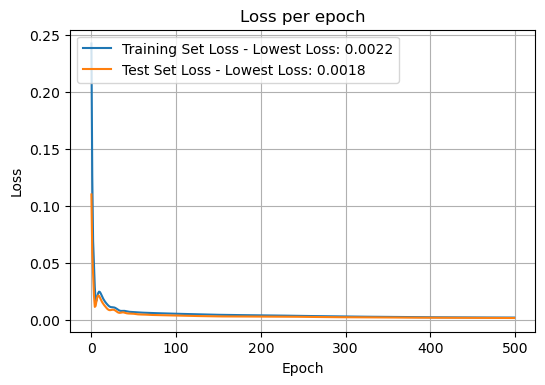

In [71]:
epochs = range(len(train_loss))

fig = plt.figure(dpi=100)
ax = fig.add_subplot()

ax.plot(epochs, train_loss, label = f'Training Set Loss - Lowest Loss: {str(round(np.min(train_loss),4))}')
ax.plot(epochs, test_loss, label = f'Test Set Loss - Lowest Loss: {str(round(np.min(test_loss),4))}')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

ax.legend(loc='upper left', prop={'size': 10})
#upper left
ax.grid(True)
plt.title("Loss per epoch")

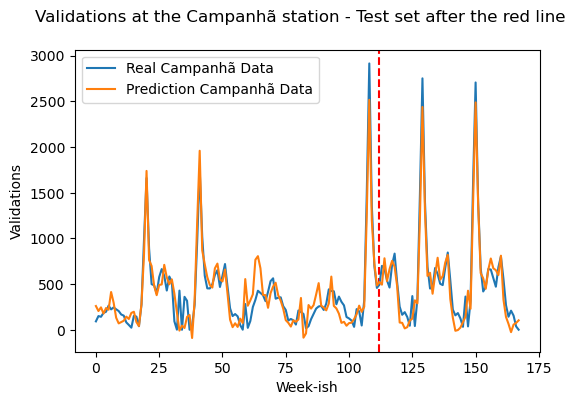

In [72]:
dataX = Variable(torch.Tensor(np.array(x)))

total_predict = lstm(dataX)
data_predict = total_predict.data.numpy()

real_data = np.array(y)

data_predict = sc.inverse_transform(data_predict)
real_data = sc.inverse_transform(real_data)

fig = plt.figure(dpi=100)
#ax = fig.add_subplot()

train_mark = int(len(real_data[0:168:,0]) * 0.67) #168 considering hourly measurements (24*7)

plt.axvline(x=train_mark, c='r', linestyle='--')

plt.plot(real_data[0:168:,0], label = "Real Campanhã Data") # Campanhã is the first column in the dataset
plt.plot(data_predict[0:168:,0], label = "Prediction Campanhã Data")
plt.suptitle('Validations at the Campanhã station - Test set after the red line')
plt.xlabel("Week-ish")
plt.ylabel("Validations")
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

Look at that! Not bad for the Campanhã station! Let's get some numbers to get a better idea of what's up (let's get some mean squared errors). There are some weird peaks going on, those are probably due to the way that we are showing the values (jumps of 168 entries) - looking at them more thoroughly, they seem to be related to peak hours.

In [73]:
data_predict.shape

(6779, 6)

In [74]:
real_data.shape

(6779, 6)

In [75]:
station_name_dict = {
    0: 'Campanhã',
    1: 'Estádio do Dragão',
    2: 'H. São João',
    3: 'Santo Ovídio',
    4: 'Srª da Hora',
    5: 'Trindade'}


error = real_data[train_size:len(real_data)]-data_predict[train_size:len(data_predict)]
absolute_error = np.abs(error)
MAE = np.mean(absolute_error, axis=0) #mean_absolute_error

for i, error_val in enumerate(MAE):
    median = np.median(real_data[train_size:len(real_data),i])
    print(f"MAE for {station_name_dict[i]} station: {round(error_val,2)}; \
(Median: {round(median,2)}; \
MAE/Median%: {round(100*error_val/median,2)}%)")

MAE for Campanhã station: 74.88; (Median: 181.89; MAE/Median%: 41.17%)
MAE for Estádio do Dragão station: 29.61; (Median: 86.0; MAE/Median%: 34.43%)
MAE for H. São João station: 32.3; (Median: 82.5; MAE/Median%: 39.15%)
MAE for Santo Ovídio station: 58.62; (Median: 123.0; MAE/Median%: 47.66%)
MAE for Srª da Hora station: 43.85; (Median: 125.0; MAE/Median%: 35.08%)
MAE for Trindade station: 207.18; (Median: 777.5; MAE/Median%: 26.65%)


It seems that the mean absolute error isn't the best, but it's alright. It seems that the model does worse in the Trindade station., and best in the H. São João station. Perhaps the Trindade station is more susceptible to less seasonality, as it the main subway hub, whereas the H. São João station may present a clearer seasonality, being close to a hospital and to a university campus.

<a id='important_graph_3'><b>Important graph 3!</b> illustrates the ability of the developed network to predict the number of expected validations at a subway station.</a>

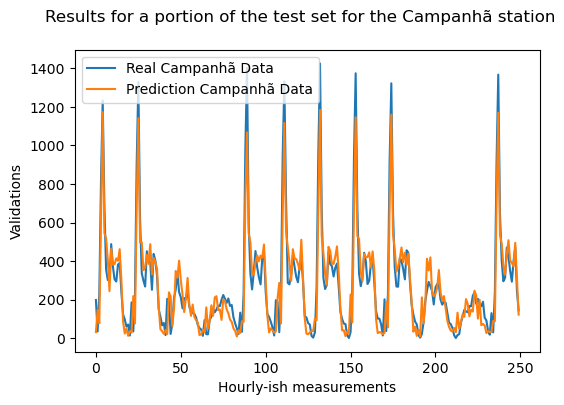

In [76]:
fig = plt.figure(dpi=100)
plt.plot(real_data[train_size:(train_size+250),0], label = "Real Campanhã Data") # Campanhã is the first column in the dataset
plt.plot(data_predict[train_size:(train_size+250),0], label = "Prediction Campanhã Data")
plt.suptitle('Results for a portion of the test set for the Campanhã station')
plt.xlabel("Hourly-ish measurements")
plt.ylabel("Validations")
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

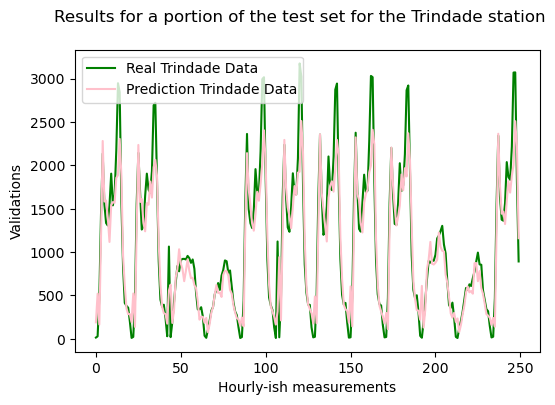

In [77]:
fig = plt.figure(dpi=100)
plt.plot(real_data[train_size:(train_size+250),5], label = "Real Trindade Data", c = 'green') # Trindade is the 6th column in the dataset
plt.plot(data_predict[train_size:(train_size+250),5], label = "Prediction Trindade Data", c = 'pink')
plt.suptitle('Results for a portion of the test set for the Trindade station')
plt.xlabel("Hourly-ish measurements")
plt.ylabel("Validations")
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

Notice how before the 50th hour mark in the Trindade graph, there is a spike that isn't well predicte by the model - looking at the overall graph you can notice the weekly seasonality, and that specific day seems to be a saturday. Perhaps in that saturday an event or something was ongoing in downtown, attracting more people than the model suspected. Also, note how the Trindade stations has two peak hours, whereas the Campanhã only really has one. Interesting stuff!

# 5. What can we do with this?

A very simple tool that we propose is aiding in determining how the number of carriages in a subway vehicle should change throughout the day. Like this:

This is what the "current past data" would look like (of the past 9 hours) for the number of validations in H. São João:

In [78]:
current_past_data = real_data[train_size:(train_size+10),2]
current_past_data

array([125.55555556,  11.        ,  68.        , 256.        ,
       323.        , 242.        , 173.        , 138.        ,
       146.        , 184.        ])

This is what hour prediction looks like for the upcoming hour:

In [79]:
prediction = data_predict[(train_size+10):(train_size+11),5]
prediction

array([1576.7776], dtype=float32)

That's quite the difference! So, what should be the percentual increase regarding the number of subway trains/number of carriages passing by?

In [80]:
100*prediction/current_past_data

array([ 1255.84061117, 14334.34232955,  2318.79067096,   615.92877197,
         488.16645704,   651.56101498,   911.43217124,  1142.59250453,
        1079.98469606,   856.9443784 ])

If the fleet in the past hours were answering to the population needs (how do we check that: subway trains with a little bit of extra space, in terms of seats - guarantees that everyone that wanted to get on was able to, without wasting too much space/energy), then we would have to increase the fleet (either subway trains or more carriages in each train) capacity by those percentages to answer to the demand expect in the next hour.

This is, of course, just an idea! There are other things to take into consideration, such as how easy is it to add more carriages to a subway train? Can you do that in those stations (beggining/end of a line)? How fast is that process? How much energy is being saved by having the optimal number of subway trains/carriages? And so on, and so on...

## 🖼️ Visualisations
Most important visualisations:

 [**Important graph 1! A boxplot that**](#important_graph_1) showed the seasonality associated with validations at subway stations, and how that is related to peak hours.
 
  [**Important graph 2! A graph that**](#important_graph_2) showed that the LSTM used was able to learn given the subway data, since both the training and test loss become quite small.
  
  [**Important graph 3! A graph that**](#important_graph_3) better illustrates the ability of the developed network to predict the number of expected validations at a subway station.

## 👓 References

Inspiring Timeseries blogpost: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

LSTM reference:
https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb